In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

df = pd.read_csv('survival.csv') #Loading the dataset.

print(df.isnull().mean().sort_values(ascending=False))       #Missing value proportions.

df_cleaned = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])        #Dropping irrelevant or high-missing-value columns from the dataset.
df_cleaned['Age'] = df_cleaned['Age'].fillna(df_cleaned['Age'].median())        #Handling missing values of Age by filling with median.
df_cleaned['Embarked'] = df_cleaned['Embarked'].fillna(df_cleaned['Embarked'].mode()[0])        #Handling missing values of Embarked by filling with mode.

# Step 3: Encode categorical variables
df_cleaned['Sex'] = df_cleaned['Sex'].map({'male': 0, 'female': 1})        # Encoding Sex as binary
df_cleaned = pd.get_dummies(df_cleaned, columns=['Embarked'], drop_first=True)        # One-hot encode Embarked

# Previewing cleaned data
print("\nCleaned data preview:")
print(df_cleaned.head())

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

Cleaned data preview:
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_Q  Embarked_S
0         0       3    0  22.0      1      0   7.2500       False        True
1         1       1    1  38.0      1      0  71.2833       False       False
2         1       3    1  26.0      0      0   7.9250       False        True
3         1       1    1  35.0      1      0  53.1000       False        True
4         0       3    0  35.0      0      0   8.0500       False        True


In [30]:

# Normalizing numerical features excluding 'Survived' as its the target variable.
features_to_scale = df_cleaned.drop(columns=['Survived']).columns
scaler = StandardScaler()
df_cleaned[features_to_scale] = scaler.fit_transform(df_cleaned[features_to_scale])

# Checking correlation matrix (optional for dimensionality reduction)
correlation_matrix = df_cleaned.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Previewing the preprocessed dataset
print("\nPreprocessed Data Preview:\n", df_cleaned.head())


Correlation Matrix:
             Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived    1.000000 -0.338481  0.543351 -0.064910 -0.035322  0.081629   
Pclass     -0.338481  1.000000 -0.131900 -0.339898  0.083081  0.018443   
Sex         0.543351 -0.131900  1.000000 -0.081163  0.114631  0.245489   
Age        -0.064910 -0.339898 -0.081163  1.000000 -0.233296 -0.172482   
SibSp      -0.035322  0.083081  0.114631 -0.233296  1.000000  0.414838   
Parch       0.081629  0.018443  0.245489 -0.172482  0.414838  1.000000   
Fare        0.257307 -0.549500  0.182333  0.096688  0.159651  0.216225   
Embarked_Q  0.003650  0.221009  0.074115 -0.031415 -0.026354 -0.081228   
Embarked_S -0.149683  0.074053 -0.119224 -0.006729  0.068734  0.060814   

                Fare  Embarked_Q  Embarked_S  
Survived    0.257307    0.003650   -0.149683  
Pclass     -0.549500    0.221009    0.074053  
Sex         0.182333    0.074115   -0.119224  
Age         0.096688   -0.031415   -0.006729  
Sib

In [31]:

# Separating features and target variables
X = df_cleaned.drop(columns=['Survived'])  # Features
y = df_cleaned['Survived']                 # Target

# Spliting data into Training+Validation (80%) and Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Spliting Training+Validation into Train (75%) and Validation (25%)
# This makes Training: 60%, Validation: 20%, Testing: 20%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Printing the shapes to verify
print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)


Training Set: (534, 8)
Validation Set: (178, 8)
Test Set: (179, 8)


In [32]:

# Defining models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=6),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "Linear Regression (converted to classifier)": LinearRegression()
}

# Storing results
results = []      
test_results = []      #storing results from test set
# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train)      #Each model is trained using training set and labeled y train.
    
    if name == "Linear Regression (converted to classifier)":
        y_prob = model.predict(X_val)
        y_pred = (y_prob >= 0.5).astype(int)     #Applying threshold of 0.5 to convert values of linear regression to 0/1.
    else:
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]      #Gives probability of 1 class.

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)       #Validation metrics

    results.append({           #Storing validation metrics.
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc
    })
    if name == "Linear Regression (converted to classifier)":          #Making test set predictions
        y_prob = model.predict(X_test)
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    test_results.append({        #this stores the test results
        "Model": name,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Test ROC AUC": roc_auc_score(y_test, y_prob)
    })

# Converting results to DataFrame
results_df = pd.DataFrame(results)
print("Model Evaluation Summary(Val set):\n", results_df)

test_df = pd.DataFrame(test_results)
print("\nTest Set Evaluation Summary:")
print(test_df)


Model Evaluation Summary(Val set):
                                          Model  Accuracy  Precision    Recall  \
0                                          KNN  0.842697   0.857143  0.705882   
1                                Decision Tree  0.837079   0.819672  0.735294   
2                                  Naive Bayes  0.797753   0.750000  0.705882   
3                          Logistic Regression  0.792135   0.746032  0.691176   
4                                          SVM  0.797753   0.750000  0.705882   
5  Linear Regression (converted to classifier)  0.797753   0.750000  0.705882   

   F1 Score   ROC AUC  
0  0.774194  0.856417  
1  0.775194  0.845321  
2  0.727273  0.836698  
3  0.717557  0.856083  
4  0.727273  0.869184  
5  0.727273  0.856350  

Test Set Evaluation Summary:
                                         Model  Test Accuracy  Precision  \
0                                          KNN       0.815642   0.833333   
1                                Decision Tree

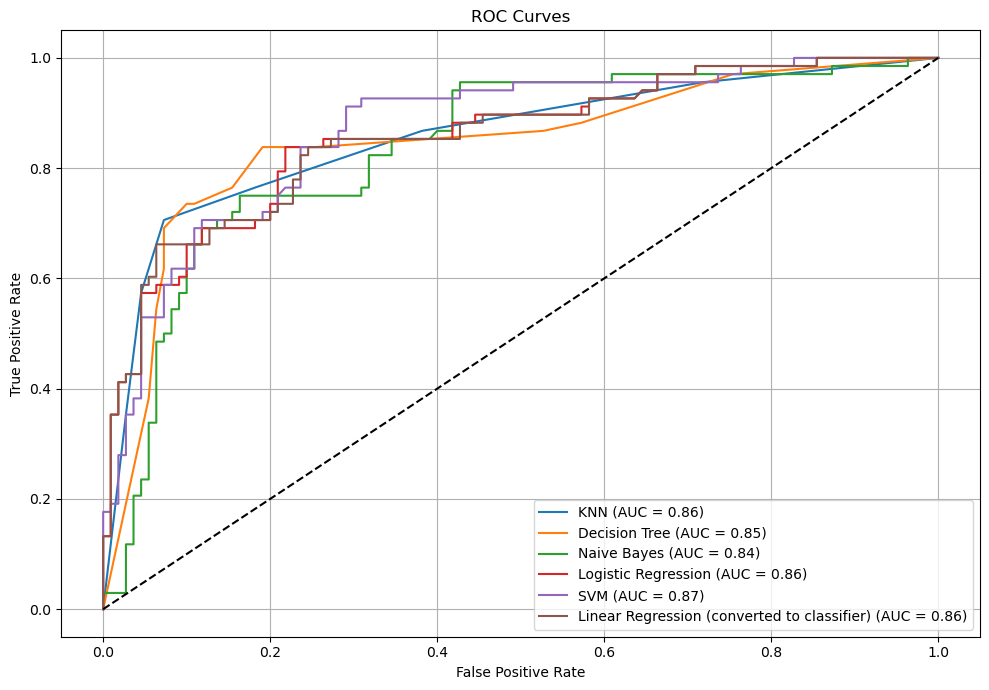

In [33]:

# Ploting ROC curves
plt.figure(figsize=(10, 7))
for name, model in models.items():
    if name == "Linear Regression (converted to classifier)":
        y_prob = model.predict(X_val)      #because of continous outputs we used predivt for the probability
    else:
        y_prob = model.predict_proba(X_val)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")    #plots the curve for the current model running in the loop

plt.plot([0, 1], [0, 1], 'k--')     #Baseline
plt.title("ROC Curves")    #graph 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()    #prevents overlapping
plt.show()

In [34]:
# ===== Hyperparameter Tuning and Evaluation =====

from sklearn.model_selection import GridSearchCV

# Defining parameter grids for tuning
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    'Decision Tree': {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]},
    'Naive Bayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
}

# Initializing base models again
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

from sklearn.metrics import roc_curve

# Storing Results
tuned_results = []     #this stores performance metrics
roc_curves_val = []
roc_curves_test = []     #thises store ROC data of validation and test sets.

for name, model in models.items():
    print(f"Tuning {name}...")
    if name in param_grids:    #Iterating through each model and tuning using grid search 
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')      #performing 5-fold cv with roc auc scoring if not just training it with normal settings
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model.fit(X_train, y_train)
        best_params = "N/A"

    # Predicting Validations
    y_val_pred = best_model.predict(X_val)
    y_val_prob = best_model.predict_proba(X_val)[:, 1]     #for auc curves

    # Making predictions for test dataset
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]

    # Storing metrics
    tuned_results.append({         #storing the metrics of validation and test sets
        "Model": name,
        "Best Params": best_params,
        "Validation Accuracy": accuracy_score(y_val, y_val_pred),
        "Validation Precision": precision_score(y_val, y_val_pred),
        "Validation Recall": recall_score(y_val, y_val_pred),
        "Validation F1": f1_score(y_val, y_val_pred),
        "Validation ROC AUC": roc_auc_score(y_val, y_val_prob),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Test F1": f1_score(y_test, y_test_pred),
        "Test ROC AUC": roc_auc_score(y_test, y_test_prob)
    })

    # Storing ROC curve data
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)     #calculating false positives and true positives rates for validation and test sets and storing them in respective lists.
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_curves_val.append((name, fpr_val, tpr_val, roc_auc_score(y_val, y_val_prob)))
    roc_curves_test.append((name, fpr_test, tpr_test, roc_auc_score(y_test, y_test_prob)))

# Converting results to DataFrame
tuned_df = pd.DataFrame(tuned_results)
print("\nTuned Model Performance:\n", tuned_df)


Tuning KNN...
Tuning Logistic Regression...
Tuning SVM...
Tuning Decision Tree...
Tuning Naive Bayes...

Tuned Model Performance:
                  Model                                        Best Params  \
0                  KNN           {'n_neighbors': 9, 'weights': 'uniform'}   
1  Logistic Regression  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...   
2                  SVM   {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}   
3        Decision Tree           {'max_depth': 3, 'min_samples_split': 2}   
4          Naive Bayes                           {'var_smoothing': 1e-09}   

   Validation Accuracy  Validation Precision  Validation Recall  \
0             0.837079              0.819672           0.735294   
1             0.797753              0.758065           0.691176   
2             0.797753              0.750000           0.705882   
3             0.848315              0.886792           0.691176   
4             0.797753              0.750000           0.705882   

   

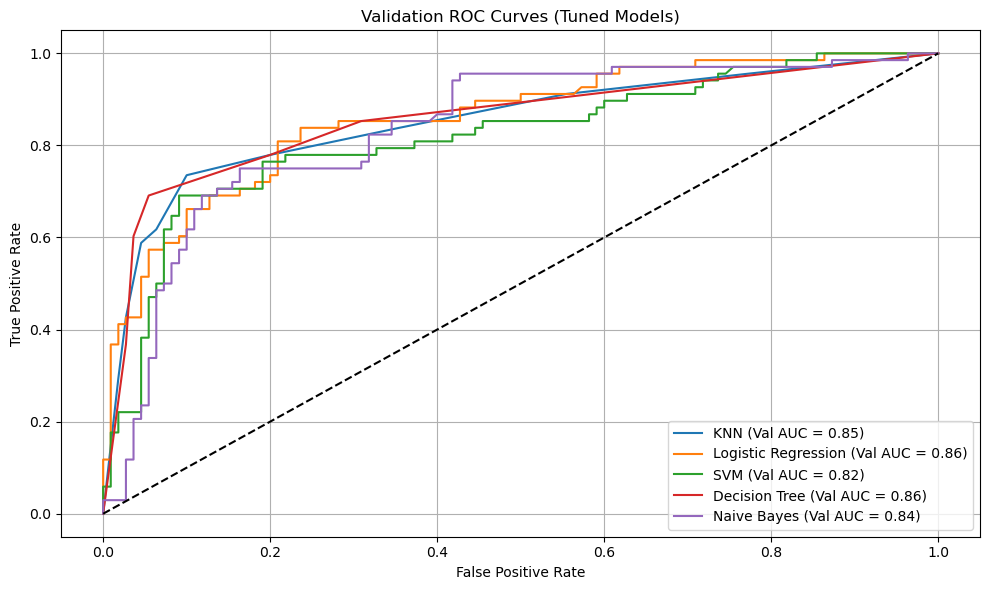

In [35]:
# === ROC Curve: Validation Set ===
plt.figure(figsize=(10, 6))
for name, fpr, tpr, auc in roc_curves_val:
    plt.plot(fpr, tpr, label=f"{name} (Val AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Validation ROC Curves (Tuned Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


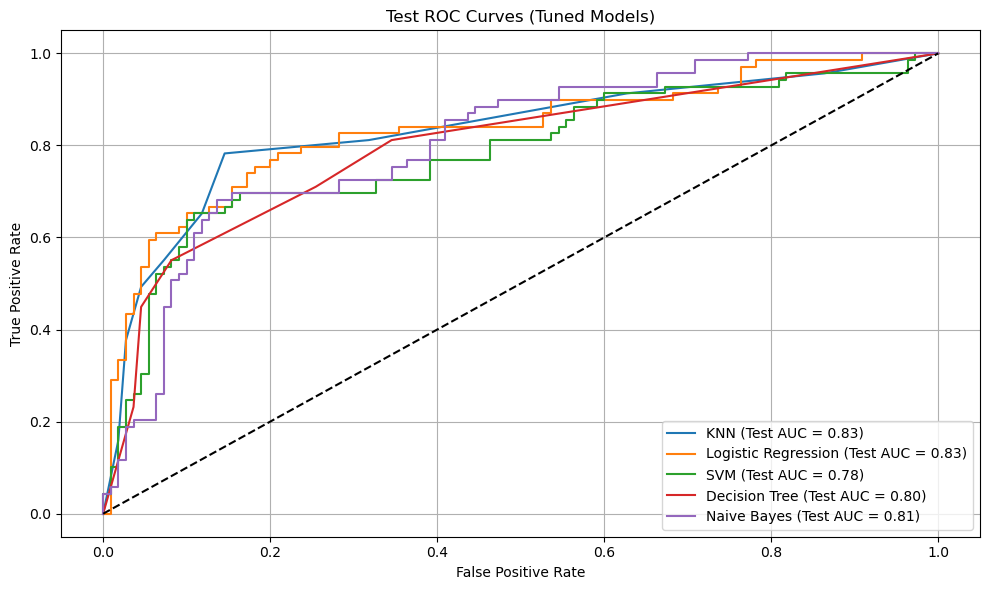

In [36]:
# === ROC Curve: Test Set ===
plt.figure(figsize=(10, 6))
for name, fpr, tpr, auc in roc_curves_test:
    plt.plot(fpr, tpr, label=f"{name} (Test AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Test ROC Curves (Tuned Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/g2/fy4r1ggx489bshthzws9y5500000gn/T/ipykernel_20066/3482603381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=survival_counts.index, y=survival_counts.values, palette=['lightblue', 'salmon'])


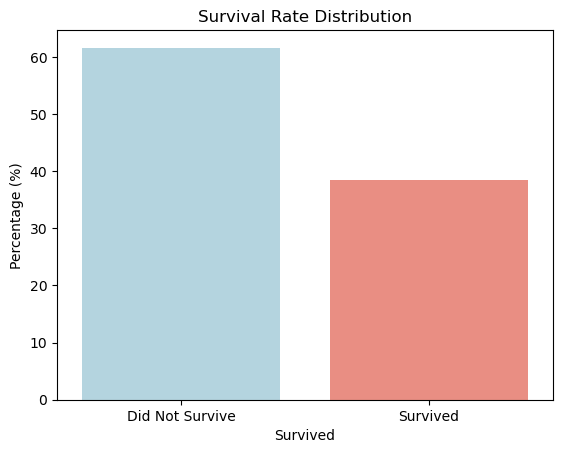

In [37]:
import seaborn as sns
survival_counts = df['Survived'].value_counts(normalize=True) * 100
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette=['lightblue', 'salmon'])
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.ylabel('Percentage (%)')
plt.title('Survival Rate Distribution')
plt.show()